# Model performance figures

In [3]:
import sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../src")
import bayesprev

In [4]:
# plot params
#sns.set(font_scale=2)
#sns.set_style('ticks')
ymin = -.1
ymax = .9
chance_level = 0.
emotions = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']
alpha = 0.05

## Preprocess results
First, load in results from validation analysis.

In [5]:
df_emo = pd.read_csv('../results/validation/target-emotion_scores.tsv', sep='\t', index_col=0)
df_emo = df_emo.sort_values(['feature_set', 'emotion'], axis=0)
df_emo['type'] = ['combined' if '+' in row['feature_set'] else
                  'dynamic' if 'dynamic' in row['feature_set'] else 'static'
                   for _, row in df_emo.iterrows()]

dfs = []
for target in ['valence', 'arousal']:
    df = pd.read_csv(f'../results/validation/target-{target}_scores.tsv', sep='\t', index_col=0)
    df['target'] = target
    dfs.append(df)

df_circ = pd.concat(dfs, axis=0)
df_circ = df_circ.sort_values('feature_set', axis=0)
df_circ['type'] = ['combined' if '+' in row['feature_set'] else
                   'dynamic' if 'dynamic' in row['feature_set'] else 'static'
                    for _, row in df_circ.iterrows()]

Also load in the the permutation results to compute significance.

In [6]:
df_emo_perm = pd.read_csv('../results/validation/target-emotion_permutationscores.tsv', sep='\t', index_col=0)
fs2type = {'vertexPCA_type-static': 'static', 'vertexPCA_type-dynamic': 'dynamic',
           'vertexPCA_type-static+vertexPCA_type-dynamic': 'combined'}
df_emo_perm['type'] = [fs2type[fs] for fs in df_emo_perm['feature_set']]

significance_emo = {'sub': [], 'type': [], 'emotion': [], 'p_val': []}
for sub in df_emo['sub'].unique():
    for tpe in fs2type.values():
        for emo in df_emo['emotion'].unique():
            score = df_emo.query("sub == @sub & type == @tpe & emotion == @emo").iloc[0, :].loc['score']
            these_perms = df_emo_perm.query("sub == @sub & type == @tpe & emotion == @emo")['score'].to_numpy()
            p = ((score <= these_perms).sum() + 1) / (these_perms.size + 1)
            significance_emo['sub'].append(sub)
            significance_emo['type'].append(tpe)
            significance_emo['emotion'].append(emo)
            significance_emo['p_val'].append(p)
            
significance_emo = pd.DataFrame(significance_emo)
significance_emo['sig'] = significance_emo['p_val'] < alpha
significance_emo.groupby(['type', 'emotion'])['sig'].sum()

type      emotion  
combined  anger        13
          disgust      13
          fear         13
          happiness    13
          sadness      13
          surprise     13
dynamic   anger        13
          disgust      13
          fear         13
          happiness    13
          sadness      13
          surprise     13
static    anger        13
          disgust       6
          fear          8
          happiness    11
          sadness       9
          surprise      3
Name: sig, dtype: int64

In [7]:
significance_circ = {'sub': [], 'type': [], 'target': [], 'p_val': []}
for target in ['valence', 'arousal']:
    df_circ_perm = pd.read_csv(f'../results/validation/target-{target}_permutationscores.tsv', sep='\t', index_col=0)
    df_circ_perm['type'] = [fs2type[fs] for fs in df_circ_perm['feature_set']]
    for sub in df_emo['sub'].unique():
        for tpe in fs2type.values():
            score = df_circ.query("sub == @sub & type == @tpe & target == @target").iloc[0, :].loc['score']
            these_perms = df_circ_perm.query("sub == @sub & type == @tpe")['score'].to_numpy()
            p = ((score <= these_perms).sum() + 1) / (these_perms.size + 1)
            significance_circ['sub'].append(sub)
            significance_circ['type'].append(tpe)
            significance_circ['target'].append(target)
            significance_circ['p_val'].append(p)
            
significance_circ = pd.DataFrame(significance_circ)
significance_circ['sig'] = significance_circ['p_val'] < alpha
significance_circ.groupby(['type', 'target'])['sig'].sum()

type      target 
combined  arousal    12
          valence    13
dynamic   arousal    12
          valence    13
static    arousal     4
          valence    13
Name: sig, dtype: int64

## Statistics
Compute prevalence inference.

0.8063958033666984
0.2598843455101615
0.38735162565820785
0.6126736860664503
0.4572809582674047
0.09954541450901781
0.8063958033666984
0.8063958033666984
0.8063958033666984
0.8063958033666984
0.8063958033666984
0.8063958033666984
0.8063958033666984
0.8063958033666984
0.8063958033666984
0.8063958033666984
0.8063958033666984
0.8063958033666984


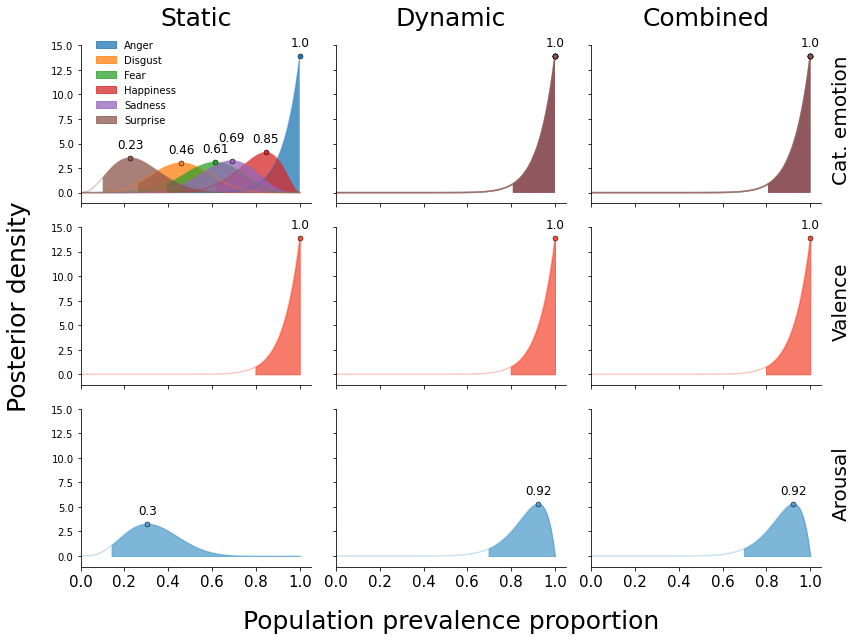

In [8]:
import matplotlib as mpl
from matplotlib.patches import Patch
np.set_printoptions(suppress=True)
mpl.rcParams['xtick.labelsize'] = 15
alpha = 0.005

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 9), sharex=True, sharey=True)
cmap = sns.color_palette()
for i, tpe in enumerate(['static', 'dynamic', 'combined']):
    df = df_emo.query("type == @tpe")
    ax = axes[0, i]
    ax.set_title(tpe.capitalize(), fontsize=25, pad=20)
    leg = [Patch(facecolor=cmap[ii], edgecolor=cmap[ii], alpha=0.75) for ii in range(6)]
    for ii, emo in enumerate(df['emotion'].unique()):
        c = cmap[ii]
        k = significance_emo.query("type == @tpe & emotion == @emo")['sig'].sum()
        n = 13
        x = np.linspace(0,1,100)
        
        posterior = bayesprev.posterior(x,k,n,alpha)
        bound = bayesprev.bound(0.95,k,n,alpha)
        print(bound)
        ax.plot(x, posterior, c=c, alpha=0.3)
        x_bounded = x[x > bound]
        posterior_bounded = bayesprev.posterior(x_bounded,k,n,alpha)
        ax.fill_between(x_bounded, posterior_bounded, np.zeros_like(x_bounded), alpha=0.75)
        
        xmap = bayesprev.map(k , n, alpha)
        pmap = bayesprev.posterior(xmap,k,n,alpha)
        ax.plot(xmap, pmap ,'.', markersize=10, c=c, markeredgecolor='k',
                markeredgewidth=0.5)
        if tpe == 'static':
            up = 1 if emo != 'sadness' else 2
        else:
            up = 1
            
        if i == 0 or ii == 0:
            ax.text(xmap, pmap + up, np.round(xmap, 2), fontsize=12, ha='center')
    
    if i == 0:
        ax.legend(leg, ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise'], frameon=False,
                  loc=(0.05, 0.47))
    elif i == 2:
        ax.text(1.1, 7.5, 'Cat. emotion', fontsize=20, rotation=90, va='center')
        
axes[1, 0].set_ylabel('Posterior density', fontsize=25, labelpad=20)    
axes[2, 1].set_xlabel('Population prevalence proportion', fontsize=25, labelpad=20)    
    
for iii, target in enumerate(['valence', 'arousal']):
    c = sns.color_palette('Reds')[3] if iii == 0 else sns.color_palette('Blues')[3]
    for i, tpe in enumerate(['static', 'dynamic', 'combined']):
        df = df_circ.query("target == @target & type == @tpe")
        ax = axes[iii+1, i]
        k = significance_circ.query("target == @target & type == @tpe")['sig'].sum()
        n = 13
        x = np.linspace(0,1,100)

        posterior = bayesprev.posterior(x,k,n,alpha)
        bound = bayesprev.bound(0.96,k,n,alpha)
        
        ax.plot(x, posterior, c=c, alpha=0.3)
        x_bounded = x[x > bound]
        posterior_bounded = bayesprev.posterior(x_bounded,k,n,alpha)
        ax.fill_between(x_bounded, posterior_bounded, np.zeros_like(x_bounded), alpha=0.75, color=c)

        xmap = bayesprev.map(k , n, alpha)
        pmap = bayesprev.posterior(xmap,k,n,alpha)
        ax.plot(xmap, pmap ,'.', markersize=10, c=c, markeredgecolor='k',
                markeredgewidth=0.5)
        ax.text(xmap, pmap + 1, np.round(xmap, 2), fontsize=12, ha='center')
        if iii == 1:
            ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

        if i == 2:
            ax.text(1.1, 7.5, target.capitalize(), fontsize=20, rotation=90, va='center')

ax.set_xlim(0, 1.05)
ax.set_ylim(-1.1, 15)
sns.despine()
fig.tight_layout()
fig.savefig('../figures/prevalence_inference_test.png', dpi=200)

## Main performance figure

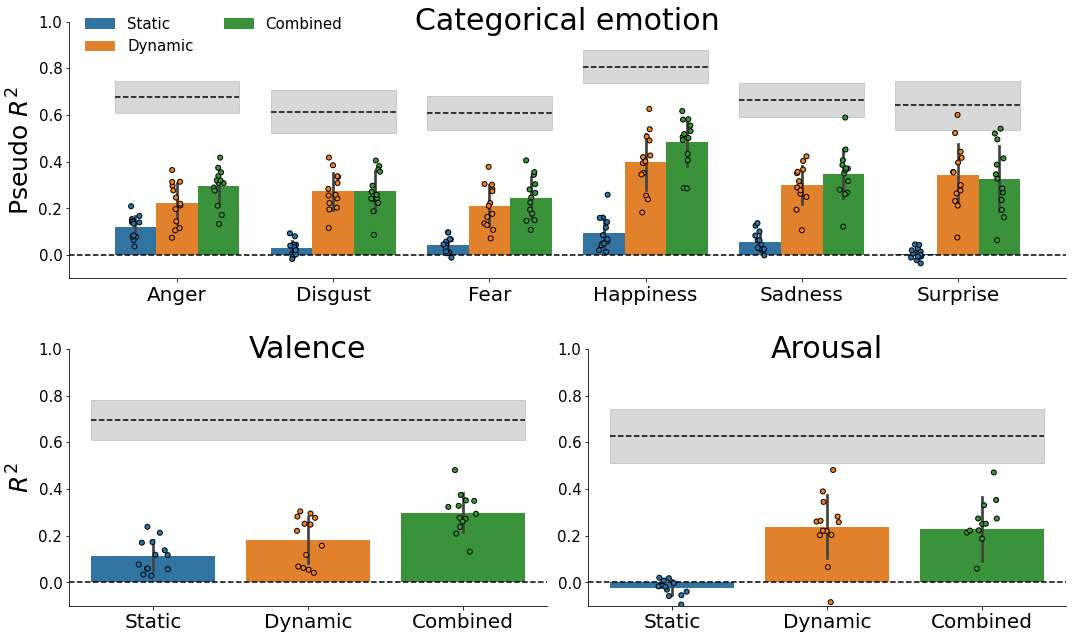

In [9]:
import matplotlib as mpl
mpl.rcParams['ytick.labelsize'] = 15

fig = plt.figure(figsize=(15, 9))
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, :])
ax = sns.barplot(
    x='emotion', y='score', hue='type', data=df_emo,
    ci='sd', ax=ax, hue_order=['static', 'dynamic', 'combined']
)
handles = ax.get_legend().legendHandles

ax = sns.stripplot(
    x='emotion', y='score', hue='type', data=df_emo,
    hue_order=['static', 'dynamic', 'combined'], ax=ax,
    dodge=True, jitter=True, edgecolor='black', linewidth=1
)
ax.legend(handles, ['Static', 'Dynamic', 'Combined'], frameon=False,
          loc=[0.01, 0.85], fontsize=15, ncol=2)
ax.set_xticklabels(emotions, fontsize=20)

# noise ceilings
nc = pd.read_csv('../results/target-emotion_noiseceilings.tsv', sep='\t')
nc['type'] = ['combined' if '+' in row['feature_space'] else
              'dynamic' if 'dynamic' in row['feature_space'] else 'static'
               for _, row in nc.iterrows()]
nc_av = nc.groupby('type').mean().drop('sub', axis=1)
nc_std = nc.groupby('type').std().drop('sub', axis=1)

for xt, idx in zip(ax.get_xticks(), nc_av.columns):
    this_nc_av = np.array([nc_av.loc['combined', idx]] * 3)
    this_nc_std = np.array([nc_std.loc['combined', idx]] * 3)
    xs = np.linspace(xt - 0.4, xt + 0.4, 3)
    ax.plot(xs, this_nc_av, ls='--', c='k')
    plt.fill_between(xs,
                     this_nc_av + this_nc_std,
                     this_nc_av - this_nc_std,
                     color='gray', alpha=0.3)

ax.set_ylim(-.1, 1)
ax.axhline(chance_level, ls='--', c='k')
ax.set_xlabel('')
ax.text(2.5, 1, 'Categorical emotion', va='center', ha='center', fontsize=30)
ax.set_ylabel(r'Pseudo $R^2$', fontsize=25)

# VALENCE/AROUSAL
nc = pd.read_csv('../results/target-valencearousal_noiseceilings.tsv', sep='\t')
nc['type'] = ['combined' if '+' in row['feature_space'] else
              'dynamic' if 'dynamic' in row['feature_space'] else 'static'
               for _, row in nc.iterrows()]
nc_av = nc.groupby('type').mean().drop('sub', axis=1)
nc_std = nc.groupby('type').std().drop('sub', axis=1)
for i, t in enumerate(['valence', 'arousal']):
    ax = fig.add_subplot(gs[1, i])
    dat = df_circ.query("target == @t")
    ax = sns.barplot(order=['static', 'dynamic', 'combined'],
                     data=dat, x='type', y='score', ci='sd', ax=ax)
    ax = sns.stripplot(order=['static', 'dynamic', 'combined'],
                       data=dat, x='type', y='score', ax=ax,
                       dodge=True, jitter=True, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('')
    ax.set_ylim(-.1, 1)
    ax.axhline(chance_level, ls='--', c='k')
    
    if i == 1:
        ax.set_ylabel('')
    else:
        ax.set_ylabel(r"$R^2$", fontsize=25)

    ax.text(1, 1, t.capitalize(), fontsize=30, va='center', ha='center')

    this_nc_av = nc_av.loc['combined', t]
    this_nc_std = nc_std.loc['combined', t]
    xs = [-0.4, 2.4]
    #xs = [xt - 0.4, xt + 0.4]
    ax.plot(xs, [this_nc_av, this_nc_av], ls='--', c='k')
    ax.fill_between(
        xs, this_nc_av + this_nc_std,
        this_nc_av - this_nc_std,
        color='gray', alpha=0.3)

    ax.set_xticklabels(['Static', 'Dynamic', 'Combined'], fontsize=20)

sns.despine()
fig.tight_layout(h_pad=3)
fig.savefig('../figures/performance_barplot.png', dpi=200)

In [10]:
from scipy.stats import ttest_rel
ttest_rel(
    df_emo.query("emotion == 'happiness' & type == 'static'").score,
    df_emo.query("emotion == 'sadness' & type == 'static'").score,
)    

Ttest_relResult(statistic=2.7598932031590717, pvalue=0.01728258168427475)

How do the combined and sum of static and dynamic compare?

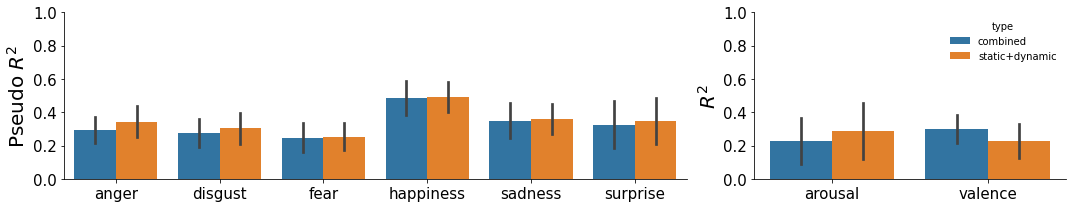

In [11]:
mpl.rcParams['legend.frameon'] = False
df_sum = df_emo.query("type == 'dynamic'").copy()
df_sum['score'] = df_emo.query("type == 'dynamic'")['score'] + df_emo.query("type == 'static'")['score']
df_sum['type'] = 'static+dynamic'
df_emo2 = pd.concat((df_emo.query("type == 'combined'"), df_sum), axis=0)

fig, axes = plt.subplots(figsize=(15, 3), ncols=2, gridspec_kw={'width_ratios': [1, 0.5]})
axes[0] = sns.barplot(data=df_emo2, x='emotion', y='score', hue='type', ci='sd', ax=axes[0])
axes[0].set_ylim(0, 1)
axes[0].get_legend().remove()
axes[0].set_ylabel(r"Pseudo $R^2$", fontsize=20)
axes[0].set_xlabel('')

df_sum = df_circ.query("type == 'dynamic'").copy()
df_sum['score'] = df_circ.query("type == 'dynamic'")['score'] + df_circ.query("type == 'static'")['score']
df_sum['type'] = 'static+dynamic'
df_circ2 = pd.concat((df_circ.query("type == 'combined'"), df_sum), axis=0)

axes[1] = sns.barplot(data=df_circ2, x='target', y='score', hue='type', ci='sd', ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_ylabel(r"$R^2$", fontsize=20)
axes[1].set_xlabel('')

sns.despine()
fig.tight_layout()
fig.savefig('../figures/combined_versus_sum_performance.png', dpi=200)

Also for the train set.

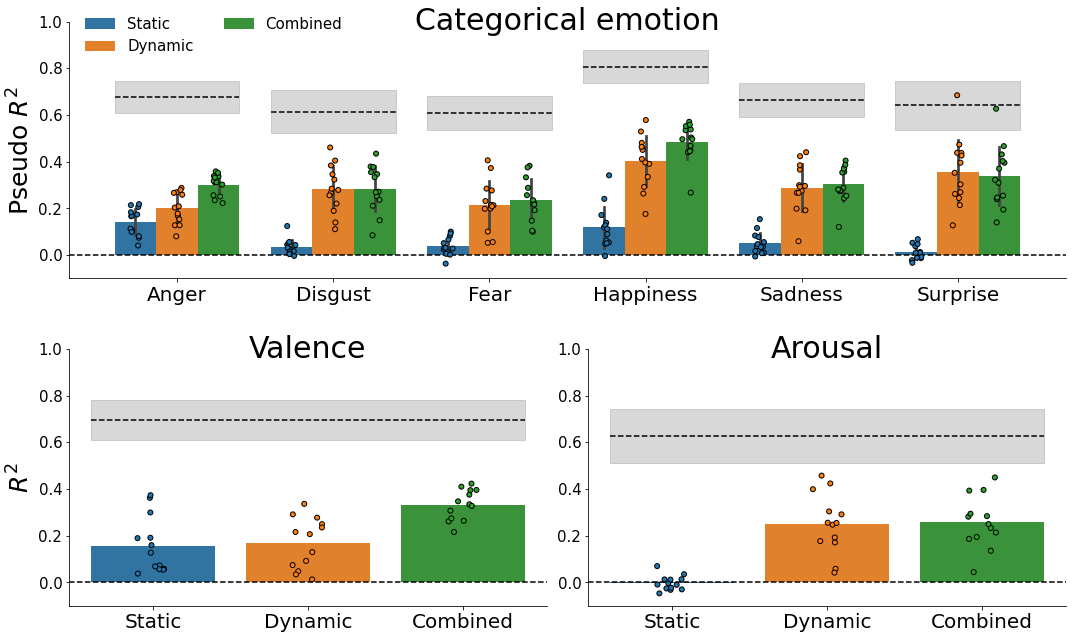

In [12]:
df_emo = pd.read_csv('../results/optimization/target-emotion_scores.tsv', sep='\t', index_col=0)
df_emo = df_emo.sort_values(['feature_set', 'emotion'], axis=0)
df_emo['type'] = ['combined' if '+' in row['feature_set'] else
                  'dynamic' if 'dynamic' in row['feature_set'] else 'static'
                   for _, row in df_emo.iterrows()]

dfs = []
for target in ['valence', 'arousal']:
    df = pd.read_csv(f'../results/optimization/target-{target}_scores.tsv', sep='\t', index_col=0)
    df['target'] = target
    dfs.append(df)

df_circ = pd.concat(dfs, axis=0)
df_circ = df_circ.sort_values('feature_set', axis=0)
df_circ['type'] = ['combined' if '+' in row['feature_set'] else
                   'dynamic' if 'dynamic' in row['feature_set'] else 'static'
                    for _, row in df_circ.iterrows()]

import matplotlib as mpl
mpl.rcParams['ytick.labelsize'] = 15

fig = plt.figure(figsize=(15, 9))
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, :])
ax = sns.barplot(
    x='emotion', y='score', hue='type', data=df_emo,
    ci='sd', ax=ax, hue_order=['static', 'dynamic', 'combined']
)
handles = ax.get_legend().legendHandles

ax = sns.stripplot(
    x='emotion', y='score', hue='type', data=df_emo,
    hue_order=['static', 'dynamic', 'combined'], ax=ax,
    dodge=True, jitter=True, edgecolor='black', linewidth=1
)
ax.legend(handles, ['Static', 'Dynamic', 'Combined'], frameon=False,
          loc=[0.01, 0.85], fontsize=15, ncol=2)
ax.set_xticklabels(emotions, fontsize=20)

# noise ceilings
nc = pd.read_csv('../results/target-emotion_noiseceilings.tsv', sep='\t')
nc['type'] = ['combined' if '+' in row['feature_space'] else
              'dynamic' if 'dynamic' in row['feature_space'] else 'static'
               for _, row in nc.iterrows()]
nc_av = nc.groupby('type').mean().drop('sub', axis=1)
nc_std = nc.groupby('type').std().drop('sub', axis=1)

for xt, idx in zip(ax.get_xticks(), nc_av.columns):
    this_nc_av = np.array([nc_av.loc['combined', idx]] * 3)
    this_nc_std = np.array([nc_std.loc['combined', idx]] * 3)
    xs = np.linspace(xt - 0.4, xt + 0.4, 3)
    ax.plot(xs, this_nc_av, ls='--', c='k')
    plt.fill_between(xs,
                     this_nc_av + this_nc_std,
                     this_nc_av - this_nc_std,
                     color='gray', alpha=0.3)

ax.set_ylim(-.1, 1)
ax.axhline(chance_level, ls='--', c='k')
ax.set_xlabel('')
ax.text(2.5, 1, 'Categorical emotion', va='center', ha='center', fontsize=30)
ax.set_ylabel(r'Pseudo $R^2$', fontsize=25)

# VALENCE/AROUSAL
nc = pd.read_csv('../results/target-valencearousal_noiseceilings.tsv', sep='\t')
nc['type'] = ['combined' if '+' in row['feature_space'] else
              'dynamic' if 'dynamic' in row['feature_space'] else 'static'
               for _, row in nc.iterrows()]
nc_av = nc.groupby('type').mean().drop('sub', axis=1)
nc_std = nc.groupby('type').std().drop('sub', axis=1)
for i, t in enumerate(['valence', 'arousal']):
    ax = fig.add_subplot(gs[1, i])
    dat = df_circ.query("target == @t")
    ax = sns.barplot(order=['static', 'dynamic', 'combined'],
                     data=dat, x='type', y='score', ci=None, ax=ax)
    ax = sns.stripplot(order=['static', 'dynamic', 'combined'],
                       data=dat, x='type', y='score', ax=ax,
                       dodge=True, jitter=True, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('')
    ax.set_ylim(-.1, 1)
    ax.axhline(chance_level, ls='--', c='k')
    
    if i == 1:
        ax.set_ylabel('')
    else:
        ax.set_ylabel(r"$R^2$", fontsize=25)

    ax.text(1, 1, t.capitalize(), fontsize=30, va='center', ha='center')

    this_nc_av = nc_av.loc['combined', t]
    this_nc_std = nc_std.loc['combined', t]
    xs = [-0.4, 2.4]
    #xs = [xt - 0.4, xt + 0.4]
    ax.plot(xs, [this_nc_av, this_nc_av], ls='--', c='k')
    ax.fill_between(
        xs, this_nc_av + this_nc_std,
        this_nc_av - this_nc_std,
        color='gray', alpha=0.3)

    ax.set_xticklabels(['Static', 'Dynamic', 'Combined'], fontsize=20)

sns.despine()
fig.tight_layout(h_pad=3)
fig.savefig('../figures/performance_barplot_train.png', dpi=200)

In [13]:
preds = {}
preds['emotion'] = pd.read_csv('../results/validation/target-emotion_preds.tsv', sep='\t', index_col=0)
preds['valence'] = pd.read_csv('../results/validation/target-valence_preds.tsv', sep='\t', index_col=0)
preds['arousal'] = pd.read_csv('../results/validation/target-arousal_preds.tsv', sep='\t', index_col=0)

<ipython-input-17-a2f25e10b04b>:12: RuntimeWarning: invalid value encountered in true_divide
  cm = np.nanmean(cms / cms.sum(axis=1, keepdims=True), axis=0)


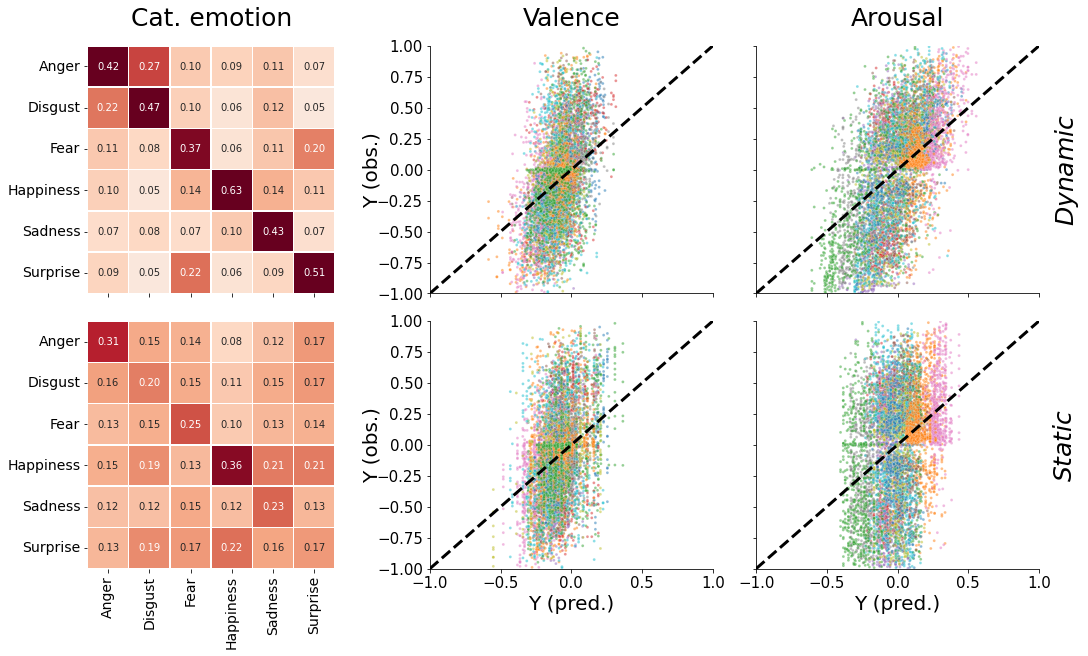

In [17]:
from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 9), sharex=False, sharey=False, constrained_layout=True)
for i, tpe in enumerate(['dynamic', 'static']):
    preds_ = preds['emotion'].query(f"feature_set == 'vertexPCA_type-{tpe}'")
    cms = np.zeros((13, 6, 6))
    for ii, sub in enumerate(preds_['sub'].unique()):
        dat = preds_.query("sub == @sub")
        y_pred = dat.iloc[:, :6].to_numpy().argmax(axis=1)
        y_true = dat['y_true'].to_numpy()
        cms[ii, :, :] = confusion_matrix(y_true, y_pred)

    cm = np.nanmean(cms / cms.sum(axis=1, keepdims=True), axis=0)
    axes[i, 0] = sns.heatmap(cm, ax=axes[i, 0], cbar=False, square=True, annot=True, linewidths=.5, cmap='RdBu_r',
                             center=0, vmax=0.4, vmin=0, annot_kws={"size": 10}, fmt='.2f')
    axes[i, 0].set_yticklabels(emotions, fontdict={'verticalalignment': 'center', 'size': 14, 'rotation': 0})
    if i == 1:
        axes[i, 0].set_xticklabels(emotions, fontdict={'horizontalalignment': 'center', 'size': 14, 'rotation': 90})
    else:
        axes[i, 0].set_xticklabels('')
 
    for ii, target in enumerate(['valence', 'arousal']):
        preds_ = preds[target].query(f"feature_set == 'vertexPCA_type-{tpe}'").copy()
        preds_.loc[:, 'true-pred'] = preds_['y_true'] - preds_['y_pred']
        sns.scatterplot(x='y_pred', y='y_true', hue='sub', data=preds_, palette='tab10',
                        ax=axes[i, ii+1], legend=False, alpha=0.5, s=8)
        axes[i, ii+1].set_ylim(-1, 1)
        axes[i, ii+1].set_xlim(-1, 1)
        axes[i, ii+1].plot(np.linspace(-1, 1), np.linspace(-1, 1), ls='--', c='k', lw=3)
        axes[i, ii+1].set_ylabel("Y (obs.)", fontsize=20, labelpad=-5)
        axes[i, ii+1].spines['right'].set_visible(False)
        axes[i, ii+1].spines['top'].set_visible(False)
    
        if ii == 1:
            axes[i, ii+1].text(1.1, 0, [r'$\it{Dynamic}$', r'$\it{Static}$'][i],
                               fontsize=25, rotation=90, va='center')
            axes[i, ii+1].set_ylabel('')
            axes[i, ii+1].set_yticklabels([])

        if i == 0:
            axes[i, ii+1].set_xticklabels([])
            axes[i, ii+1].set_xlabel('')
        else:
            axes[i, ii+1].set_xlabel('Y (pred.)', fontsize=20)
for i, name in enumerate(['Cat. emotion', 'Valence', 'Arousal']):
    axes[0, i].set_title(name, fontsize=25, pad=20)
    
plt.savefig('../figures/predictions_perf.png', dpi=200)